# Imports

In [347]:
import cvxpy
import matplotlib.pyplot as plt
import numpy
import numpy.random
from scipy.optimize import least_squares, shgo, direct
from tqdm.notebook import tqdm

%run unit_exponentials.ipynb

# Useful mathematical functions

In [77]:
def powermean(xx,mean_power=1.0):
    #print(f"xx:{xx}, mean_power:{mean_power}")
    average = numpy.average(numpy.power(xx,mean_power))
    return numpy.sign(average)*numpy.power(numpy.abs(average),1.0/mean_power)

# Hyperparameters

In [2]:
# Number of unit exponentials to add
n = 7
#n = 25

# Boundaries of multiplier arguments
min_k = 1.25
max_k = 2.25
#min_k = 1.01
#max_k = 1.25

# Maximum weight multiplier
r = 3

# Initial value for weights
default_w = 0.5

# Initial value for k_0
default_initial_k = 0.5

# Initial value for other k_j
default_k = 2
#default_k = 1.1

# Sums of unit exponentials

In [3]:
# params should be an array [k_0,w_1,k_1,w_2,...,w_n]
def uexp_sum(params, n=n, **kwargs):
    k0 = params[0]
    cur_t = k0
    cur_w = params[1]
    uexps = [uexp(cur_t)]
    ww = [cur_w]

    for i in range(1,n):
        cur_k = params[2*i]
        cur_t = cur_t * cur_k
        uexps.append(uexp(cur_t))
        
        cur_w = params[2*i+1]
        ww.append(cur_w)

    def uexp_sum_f(x):
        result = 0.0
        for i in range(n):
            w = ww[i]
            uexp_f = uexps[i]

            result += w * uexp_f(x)

        return result

    return uexp_sum_f

In [4]:
def uexp_sum_str(params, n=n, **kwargs):
    k0 = params[0]
    cur_t = k0
    cur_w = params[1]

    result = f"{cur_w:.2f}uexp({cur_t:.2f})"

    for i in range(1,n):
        cur_k = params[2*i]
        cur_t = cur_t * cur_k
        cur_w = params[2*i+1]
        result += f" + {cur_w:.2f}uexp({cur_t:.2f})"

    return result

# Least squares fitting

In [5]:
def residuals_absolutely_monotonic_fit_parametric(params, xx, yy, **kwargs):            
    f = uexp_sum(params, **kwargs)

    fxx = f(xx)
    
    return yy - fxx
    
def absolutely_monotonic_fit_parametric(xx, yy, n=n,min_k=min_k,max_k=max_k,default_initial_k=default_initial_k,default_k=default_k,default_w=default_w,r=r,**kwargs):        
    max_y = numpy.max(yy)
    
    min_bounds = [0,0]
    max_bounds = [max_k,r*max_y]
    initial_params = [default_initial_k,default_w]
    
    for i in range(1,n):
        min_bounds.append(min_k)
        min_bounds.append(0)
        max_bounds.append(max_k)
        max_bounds.append(r*max_y)
        initial_params.append(default_k)
        initial_params.append(default_w)
    
    residuals_lambda = lambda params:residuals_absolutely_monotonic_fit_parametric(params,xx,yy,n=n,**kwargs)    
    
    result = least_squares(residuals_lambda, initial_params, bounds=(min_bounds,max_bounds))

    return result.x

# Sum of positive monomials

## Discrete differences

In [36]:
# Returns an array of arrays.
# Position 0 is the degree 0 differences (actual values) - n elements
# Position 1 is the degree 1 differences (slope between subsequent points) - n-1 elements
# Position 2 is the degree 2 differences (curvature between 3 subsequent points / slope between 2 slopes) - n-2 elements
# etc.
def calculate_differences(xx, yy, max_degree):
    n = len(xx)
    max_degree = min(max_degree, n-1)

    result = [yy]
    for i in range(max_degree):
        prev_yy = result[-1]
        new_differences = numpy.array([(prev_yy[j+1] - prev_yy[j])/(xx[i+j+1]-xx[i+j]) for j in range(len(prev_yy)-1)])
        result.append(new_differences)

    return result

def minimum_difference(xx, yy, max_degree):
    differences = calculate_differences(xx,yy,max_degree)
    return numpy.min([numpy.min(i_diff) for i_diff in differences])

## Monomials

In [185]:
max_monomial_coef = 5
diff_margin = 0.05

In [363]:
def monomial(xx, degree, coef):
    return coef*numpy.power(xx,degree)

# Returns the optimal coefficient (using a powermean of differences)
# max_degree is the maximum degree of differences to evaluate
# diff_margin is the margin to allow differences to go into the negative. Currently an absolute value.
def optimize_coef_monomial(xx, yy, degree, max_degree, diff_margin = diff_margin, max_monomial_coef=max_monomial_coef, **kwargs):
    def ff_coef(coef):
        return monomial(xx,degree,coef)

    def deltas_coef(coef):
        return yy - ff_coef(coef)

    def obj_func(coef):
        deltas = deltas_coef(coef)        
        return float(powermean(deltas,**kwargs))

    def constraint_differences(coef):
        deltas = deltas_coef(coef)
        min_diff = minimum_difference(xx,deltas,max_degree)
        return float(min_diff+diff_margin)

    bounds = [(0,max_monomial_coef)]
    cons = [{
            'type': 'ineq', 
             'fun': constraint_differences}]

    #result = shgo(obj_func, bounds, constraints=cons,minimizer_kwargs={"method": "SLSQP"})
    result = shgo(obj_func, bounds)

    if result.x is None or not result.success:
        return 0.0, obj_func(0.0)

    return result.x[0], result.fun

In [365]:
max_polynomial_degree = 15
max_initial_degree = 3
min_max_degree = 1
min_diff_prop = 0.01

In [366]:
def candidate_degrees_all(max_polynomial_degree=max_polynomial_degree):
    return range(1,max_polynomial_degree+1)

def discrete_optimize_scan(obj_fun,candidates):
    min_value = numpy.inf
    min_candidate = None
    for candidate in candidates:
        value = obj_fun(candidate)
        #print(f"candidate:{candidate}, value:{value}")
        if value < min_value:
            min_candidate = candidate
            min_value = value

    return min_candidate,min_value

In [367]:
def optimize_degree_monomial(xx, yy, candidate_degrees=candidate_degrees_all, max_initial_degree = max_initial_degree, min_diff_prop=min_diff_prop, **kwargs):    
    bounds = [(1,max_polynomial_degree)]
    mean_yy = numpy.average(yy)    

    max_degree = max_initial_degree
    while max_degree >= min_max_degree:
        #print(f"max_degree = {max_degree}")
        def obj_func(degree):
            coef, diff = optimize_coef_monomial(xx, yy, degree, max_degree, **kwargs)
    
            return diff
        
        degree,diff = discrete_optimize_scan(obj_func,candidate_degrees())        
        coef, diff = optimize_coef_monomial(xx, yy, degree, max_degree, **kwargs)

        #print(f"degree: {degree}, coef: {coef}, diff: {diff}")
        diff_prop = 1.0 - diff/mean_yy
        #print(f"diff_prop: {diff_prop}")
        if diff_prop < min_diff_prop:
            max_degree -= 1
            continue
        else:
            return degree, coef, diff

    return 0, 0, 0

In [368]:
initial_reserve = 0.4
reserve_factor = 0.8
mean_power = 2

In [369]:
def decompose_monomial_sum(xx, yy, initial_reserve = initial_reserve, reserve_factor = reserve_factor, mean_power=mean_power, min_diff_prop=min_diff_prop, **kwargs):
    mean_yy = numpy.average(yy)
    
    result = {}
    cur_reserve = initial_reserve

    diff_prop = 1.0    
    remaining_diff = 1.0
    while diff_prop > min_diff_prop:
        degree, coef, diff = optimize_degree_monomial(xx, yy, min_diff_prop=min_diff_prop, mean_power=mean_power)        
        #print(f"degree: {degree}, coef: {coef}, diff: {diff}")

        diff_prop = remaining_diff*(1.0 - diff/mean_yy)
        #print(f"diff_prop:{diff_prop}")

        if diff_prop < min_diff_prop:
            break

        cur_factor = 1.0 - cur_reserve
        
        cur_coef = result.get(degree,0)
        cur_coef += cur_factor*coef

        result[degree] = cur_coef

        yy = yy - monomial(xx, degree, coef*cur_factor)
        cur_reserve *= reserve_factor       
        remaining_diff -= cur_factor*diff_prop

    return result

In [370]:
def monomial_sum(xx,params):
    result = numpy.zeros_like(xx)
    for degree,coef in params.items():
        result += monomial(xx,degree,coef)

    return result

def monomial_sum_str(params):
    result = ""
    for degree,coef in params.items():
        result += f" + {coef}x^{degree}"

    return result

In [371]:
min_final_coef_prop=0.05

In [372]:
def filter_monomial_sum(sum_dict,min_final_coef_prop=min_final_coef_prop):
    max_coef = 0.0
    for degree,coef in sum_dict.items():
        if coef > max_coef:
            max_coef = coef

    if max_coef == 0.0:
        return sum_dict
        
    result = {}
    for degree,coef in sum_dict.items():
        if coef/max_coef > min_final_coef_prop:
            result[degree] = coef

    return result

In [373]:
reps = 50
for i in range(reps):
    n = 20
    xx = numpy.sort(numpy.random.rand(n))    
    mean_power = 2
    
    yy = 0.75*(numpy.exp(xx)-1)+3.5*xx*xx+0.24*(numpy.exp(xx*xx)-1)    
    
    result = filter_monomial_sum(decompose_monomial_sum(xx, yy, mean_power=mean_power))

    print(result)    
    print(yy)
    print(monomial_sum(xx,result))
    print("---")

{2: 4.5710449706109415, 1: 0.5478906369095979}
[0.24216741 0.50587798 0.53393032 0.76366025 0.79421203 1.00176721
 1.01524996 1.16125154 1.38763326 1.59660771 1.69890187 1.75465038
 2.29254108 2.74578439 2.82077549 3.16917756 4.02536436 4.12012517
 4.48625818 4.51296703]
[0.22038958 0.48126494 0.50938148 0.74092393 0.77183685 0.98224017
 0.9959239  1.14415691 1.3740086  1.58596413 1.68958381 1.7460093
 2.28834982 2.74172165 2.81636601 3.16167081 3.99889627 4.09049228
 4.44227606 4.46780363]
---
{2: 4.546072538559723, 1: 0.5639375253683617}
[0.07192057 0.10363254 0.22099061 0.86184248 1.3731566  1.46356272
 1.89885413 1.92295753 2.31696958 2.69715061 3.13322087 3.15909487
 3.26475349 3.33043668 3.61077276 3.87408022 4.171297   4.20151881
 4.31264062 5.08042243]
[0.06103816 0.09007747 0.20179021 0.84284161 1.3611932  1.45277648
 1.8926222  1.91691012 2.31269212 2.69205926 3.1237178  3.14920503
 3.25313319 3.31761684 3.59173795 3.8475388  4.13426031 4.1632917
 4.26983738 4.99714994]
---
{

# Evaluation

In [335]:
def generate_sample(f,number_samples=200,gaussian_noise_std_mult=0,**kwargs):       
    xx = numpy.sort(numpy.random.random_sample(number_samples))
    yy = f(xx)

    # Add noise
    if gaussian_noise_std_mult > 0:
        noise = numpy.random.normal(scale=gaussian_noise_std_mult*f(1),size=number_samples)        
    else:
        noise = 0

    return (xx,yy+noise)

number_samples_test=200
# Returns a dictionary with entries:
#  - xx
#  - yy
#  - params
#  - fit_nmse
#  - source_nmse
def evaluate_absolutely_monotonic_fit(f,number_samples,number_samples_test=number_samples_test,**kwargs):
    (xx,yy) = generate_sample(f,number_samples=number_samples,**kwargs)

    params = absolutely_monotonic_fit_parametric(xx,yy,**kwargs)

    fit_residuals = residuals_absolutely_monotonic_fit_parametric(params, xx, yy, **kwargs)

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    source_residuals = residuals_absolutely_monotonic_fit_parametric(params, xx2, yy2, **kwargs)

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy": yy, "params":params, "fit_nmse":fit_nmse, "source_nmse":source_nmse}

def evaluate_monomial_sum_fit(f,number_samples,number_samples_test=number_samples_test,**kwargs):
    (xx,yy) = generate_sample(f,number_samples=number_samples,**kwargs)

    params = filter_monomial_sum(decompose_monomial_sum(xx, yy, **kwargs))

    fit_residuals = yy - monomial_sum(xx,params)

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    source_residuals = yy2 - monomial_sum(xx2,params)

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy": yy, "params":params, "fit_nmse":fit_nmse, "source_nmse":source_nmse}

In [351]:
def plot_absolutely_monotonic_fit(f, f_desc, params, xx, yy, **kwargs):    
    oo = numpy.linspace(0,1,200)
    
    original_ff = f(oo)

    fitted_f = uexp_sum(params,**kwargs)
    fitted_ff = fitted_f(oo)
    
    plt.plot(oo,original_ff,c="c",linestyle="dotted",alpha=1,label=f_desc)
    plt.plot(oo,fitted_ff,c="r",linestyle="dashed",alpha=1,label=uexp_sum_str(params,**kwargs))
    plt.scatter(xx,yy,c="k",alpha=0.1,marker="x",label="Fit to sampled points")   

def plot_monomial_sum_fit(f, f_desc, params, xx, yy, **kwargs):    
    oo = numpy.linspace(0,1,200)
    
    original_ff = f(oo)

    fitted_ff = monomial_sum(oo,params)
    
    plt.plot(oo,original_ff,c="c",linestyle="dotted",alpha=1,label=f_desc)
    plt.plot(oo,fitted_ff,c="r",linestyle="dashed",alpha=1,label=monomial_sum_str(params,**kwargs))
    plt.scatter(xx,yy,c="k",alpha=0.1,marker="x",label="Fit to sampled points")   

In [348]:
# Using cvxpy
def cvxpy_fit(f, xx, yy, number_samples_test=number_samples_test,**kwargs):
    l = len(xx)
    ff_var = cvxpy.Variable(l)

    objective = cvxpy.Minimize(cvxpy.sum_squares(ff_var - yy))

    constraints = [
        ( (ff_var[i+2] - ff_var[i+1]) / (xx[i+2] - xx[i+1]) -
          (ff_var[i+1] - ff_var[i]) / (xx[i+1] - xx[i]) ) >= 0
        for i in range(l - 2)
    ]

    problem = cvxpy.Problem(objective, constraints)
    problem.solve()

    ff = ff_var.value

    fit_residuals = ff-yy

    fit_mse = numpy.average(fit_residuals * fit_residuals)
    fit_nmse = fit_mse/f(1)

    xx2 = numpy.linspace(0,1,number_samples_test)
    yy2 = f(xx2)
    ff2 = numpy.interp(xx2,xx,ff)
    source_residuals = ff2-yy2

    source_mse = numpy.average(source_residuals * source_residuals)
    source_nmse = source_mse/f(1)

    return {"xx": xx, "yy":yy, "ff":ff, "fit_nmse":fit_nmse, "source_nmse":source_nmse}

def plot_cvxpy_fit(f, f_desc, xx, ff, **kwargs):    
    plt.plot(xx,ff,c="y",linestyle="dashdot",alpha=1,label="Convex fit")

In [337]:
number_tests = 100
def absolutely_monotonic_fit_many(f,number_samples,number_tests=number_tests,**kwargs):
    results = []
    #for i in tqdm(range(number_tests)):
    for i in range(number_tests):
        result = evaluate_absolutely_monotonic_fit(f,number_samples,**kwargs)

        results.append(result)

        if i % 10 == 9:
            print(f"{i+1} tests completed")

    results_source_nmse = numpy.array([result["source_nmse"] for result in results])

    max_source_nmse = numpy.max(results_source_nmse)
    avg_source_nmse = numpy.average(results_source_nmse)
    avg_diffs = numpy.abs(results_source_nmse - avg_source_nmse)
    min_avg_diff = numpy.min(avg_diffs)

    max_result = [result for result in results if result["source_nmse"] == max_source_nmse][0]
    avg_result = [result for result in results if numpy.abs(result["source_nmse"]-avg_source_nmse) == min_avg_diff][0]

    return {"max_source_nmse":max_source_nmse, "avg_source_nmse":avg_source_nmse, "avg_result":avg_result, "worst_result":max_result}

number_tests = 100
def monomial_sum_fit_many(f,number_samples,number_tests=number_tests,**kwargs):
    results = []
    #for i in tqdm(range(number_tests)):
    for i in range(number_tests):
        result = evaluate_monomial_sum_fit(f,number_samples,**kwargs)

        results.append(result)

        if i % 10 == 9:
            print(f"{i+1} tests completed")

    results_source_nmse = numpy.array([result["source_nmse"] for result in results])

    max_source_nmse = numpy.max(results_source_nmse)
    avg_source_nmse = numpy.average(results_source_nmse)
    avg_diffs = numpy.abs(results_source_nmse - avg_source_nmse)
    min_avg_diff = numpy.min(avg_diffs)

    max_result = [result for result in results if result["source_nmse"] == max_source_nmse][0]
    avg_result = [result for result in results if numpy.abs(result["source_nmse"]-avg_source_nmse) == min_avg_diff][0]

    return {"max_source_nmse":max_source_nmse, "avg_source_nmse":avg_source_nmse, "avg_result":avg_result, "worst_result":max_result}

In [338]:
def plot_full_result_absolutely_monotonic_fit(fit_function, function_desc,
                                              number_samples, number_samples_test, gaussian_noise_std_mult,
                                              result):
    params = result["params"]
    xx = result["xx"]
    yy = result["yy"]
    fit_nmse = result["fit_nmse"]
    source_nmse = result["source_nmse"]
    
    result_cvxpy = cvxpy_fit(fit_function,
                             xx,
                             yy,
                             number_samples_test=number_samples_test)
    
    ff_cvxpy = result_cvxpy["ff"]
    fit_nmse_cvxpy = result_cvxpy["fit_nmse"]
    source_nmse_cvxpy = result_cvxpy["source_nmse"]                        
    
    
    if gaussian_noise_std_mult == 0:
        plot_title = f"Absolutely monotonic fit for {function_desc} (N={number_samples})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
    else:
        plot_title = f"Absolutely monotonic fit for {function_desc} (N={number_samples}, gaussian noise std={gaussian_noise_std_mult:.2f})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
        
    plot_absolutely_monotonic_fit(fit_function,function_desc,params,xx,yy)
    plot_cvxpy_fit(fit_function,function_desc,xx,ff_cvxpy)
    
    ax = plt.gca()
    ax.set_xlim([0,1])
    
    plt.title(plot_title)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize="x-small")
        
    plt.show()

def plot_full_result_monomial_sum_fit(fit_function, function_desc,
                                              number_samples, number_samples_test, gaussian_noise_std_mult,
                                              result):
    params = result["params"]
    xx = result["xx"]
    yy = result["yy"]
    fit_nmse = result["fit_nmse"]
    source_nmse = result["source_nmse"]
    
    result_cvxpy = cvxpy_fit(fit_function,
                             xx,
                             yy,
                             number_samples_test=number_samples_test)
    
    ff_cvxpy = result_cvxpy["ff"]
    fit_nmse_cvxpy = result_cvxpy["fit_nmse"]
    source_nmse_cvxpy = result_cvxpy["source_nmse"]                        
    
    
    if gaussian_noise_std_mult == 0:
        plot_title = f"Absolutely monotonic polynomial fit for {function_desc} (N={number_samples})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
    else:
        plot_title = f"Absolutely monotonic polynomial fit for {function_desc} (N={number_samples}, gaussian noise std={gaussian_noise_std_mult:.2f})\n" +\
                        f"Fit NMSE={fit_nmse:.2e}, Source NMSE={source_nmse:.2e}\n" +\
                        f"cvxpy Fit NMSE={fit_nmse_cvxpy:.2e}, cvxpy Source NMSE={source_nmse_cvxpy:.2e}\n"
        
    plot_monomial_sum_fit(fit_function,function_desc,params,xx,yy)
    plot_cvxpy_fit(fit_function,function_desc,xx,ff_cvxpy)
    
    ax = plt.gca()
    ax.set_xlim([0,1])
    
    plt.title(plot_title)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fontsize="x-small")
        
    plt.show()

## Evaluated functions

In [342]:
f1_desc = "e^x - normalized"
f1_zero = 1
f1_factor = numpy.divide(1.0,numpy.exp(1)-f1_zero)
def f1(x):
    return f1_factor*(numpy.exp(x) - f1_zero)

f2_desc = "e^(e^x) - normalized"
f2_zero = numpy.exp(1)
f2_factor = numpy.divide(1.0,numpy.exp(numpy.exp(1))-f2_zero)
def f2(x):
    return f2_factor*(numpy.exp(numpy.exp(x)) - f2_zero)

f3_desc = "e^(e^(e^x)) - normalized"
f3_zero = numpy.exp(numpy.exp(1))
f3_factor = numpy.divide(1.0,numpy.exp(numpy.exp(numpy.exp(1)))-f3_zero)
def f3(x):
    return f3_factor*(numpy.exp(numpy.exp(numpy.exp(x))) - f3_zero)

f4_desc = "x^2"
def f4(x):
    return x*x

f5_desc = "x^5+2x^4+x^3+x"
def f5(x):
    return numpy.power(x,5) + 2*numpy.power(x,4) + numpy.power(x,3) + x

f6_desc = "3x^2-x^3"
def f6(x):
    return 3*numpy.power(x,2) - numpy.power(x,3)

f7_desc = "x^4-4x^3+6x^2"
def f7(x):
    return numpy.power(x,4)-4*numpy.power(x,3)+6*numpy.power(x,2)

f8_desc = "sin(pi/2 x - pi/2) + 1"
def f8(x):
    return numpy.sin(x*numpy.pi/2 - numpy.pi/2) + 1

f9_desc = "4x^2 {[0,0.5]} || 4x-1 {[0.5,1]}"
def f9(x):
    return numpy.where(x < 0.5, 4*numpy.power(x,2), 4*x-1)

10 tests completed
20 tests completed


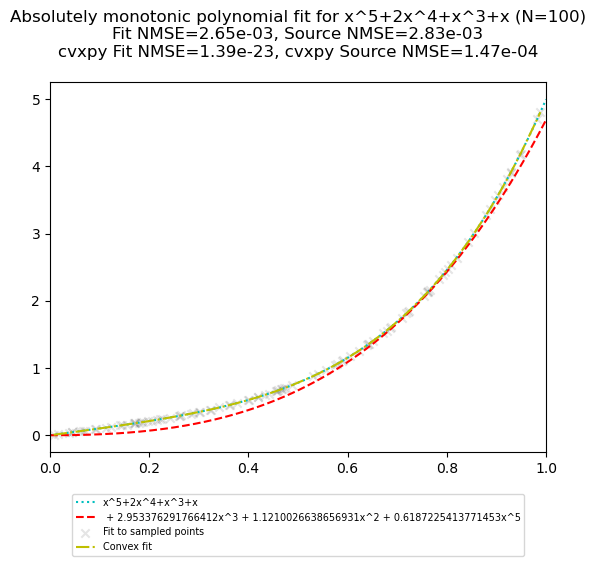

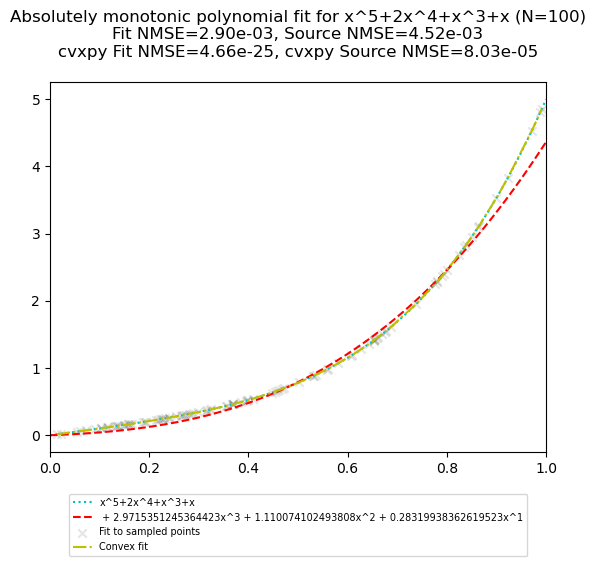

In [385]:
number_samples = 100
number_samples_test=50
number_tests = 20
gaussian_noise_std_mult=0
fit_function = f5
function_desc = f5_desc

many_results = monomial_sum_fit_many(fit_function, number_samples, number_tests, gaussian_noise_std_mult=gaussian_noise_std_mult)

avg_result = many_results["avg_result"]
worst_result = many_results["worst_result"]

plot_full_result_monomial_sum_fit(fit_function, function_desc, number_samples, number_samples_test, gaussian_noise_std_mult, avg_result)
plot_full_result_monomial_sum_fit(fit_function, function_desc, number_samples, number_samples_test, gaussian_noise_std_mult, worst_result)